In [61]:
import numpy as np
from control import dlqr    
from qpsolvers import solve_qp
%matplotlib ipympl
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, HalfspaceIntersection
from shapely.geometry import Polygon
import geopandas as gpd

In [62]:
def sample_points(A, b, x_range, y_range, delta=0.1):
    x_list = np.arange(x_range[0], x_range[1] + delta, delta)
    y_list = np.arange(y_range[0], y_range[1] + delta, delta)
    points = []
    for x in x_list:
        for y in y_list:
            if np.all(A @ np.array([x, y]) <= b):
               points.append([x, y])
               
    return points

def box_constraints(lb, ub):
    num_con = 2 * len(lb)
    A = np.kron(np.eye(len(lb)), [[1], [-1]])

    b = np.zeros(num_con)
    for i in range(num_con):
        b[i] = ub[i // 2] if i % 2 == 0 else -lb[i // 2]

    goodrows = np.logical_and(~np.isinf(b), ~np.isnan(b))
    A = A[goodrows]
    b = b[goodrows]
    
    return A, b

def plot_polygon(A, b):
    halfspaces = np.hstack((A, -b[:, np.newaxis]))
    feasible_point = np.array([0., 0.])
    hs = HalfspaceIntersection(halfspaces, feasible_point)
    polygon = Polygon(hs.intersections).convex_hull
    polygon_gpd = gpd.GeoSeries(polygon)
    polygon_gpd.plot(alpha=0.25)
    plt.plot(*polygon.exterior.xy, 'ro')
    plt.axis('equal')
    plt.grid()

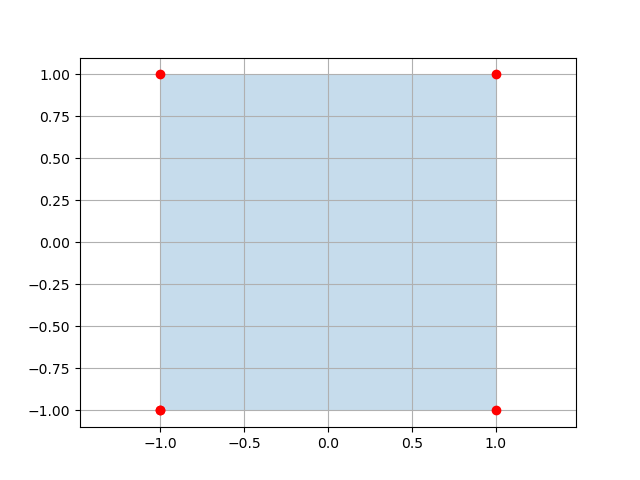

In [63]:
dim_x = 2
dim_u = 1
A = np.array([[2., 1.], [0., 2.]])
B = np.array([[0.], [1.]])

Q = np.eye(dim_x)
R = 3
K = dlqr(A, B, Q, R)[0]
K = -K  # sign convention

lb_x = [-1., -1.]
ub_x = [1., 1.]
lb_u = [-5.5]
ub_u = [5.5]

A_x, b_x = box_constraints(lb_x, ub_x)
A_u, b_u = box_constraints(lb_u, ub_u)

A_lqr = A_u @ K
b_lqr = b_u

A_con = np.vstack((A_lqr, A_x))
b_con = np.hstack((b_lqr, b_x))

plot_polygon(A_con, b_con)

points = sample_points(A_con, b_con, [lb_x[0], ub_x[0]], [lb_x[1], ub_x[1]])

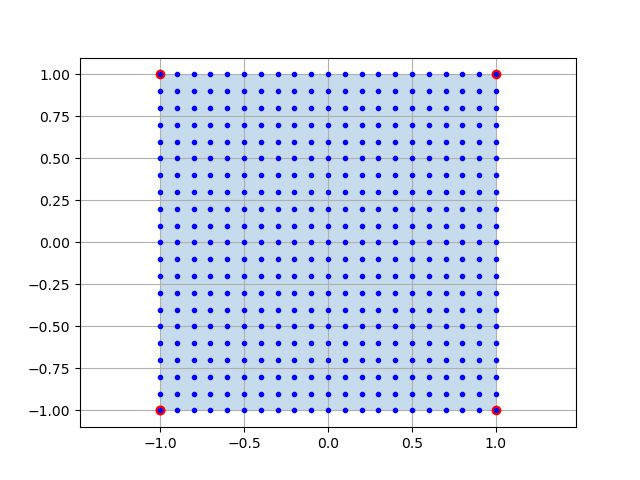

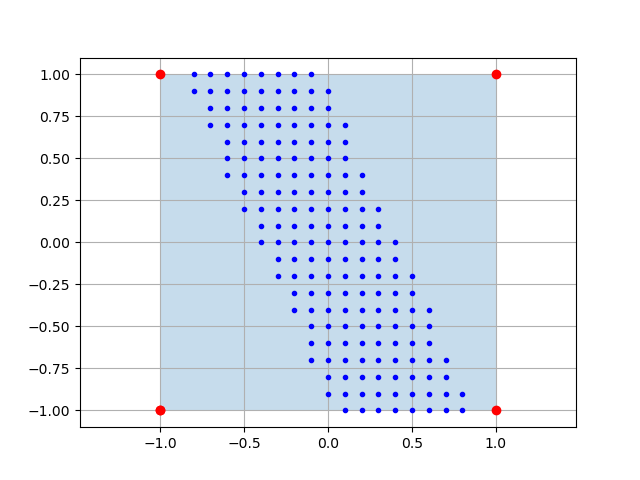

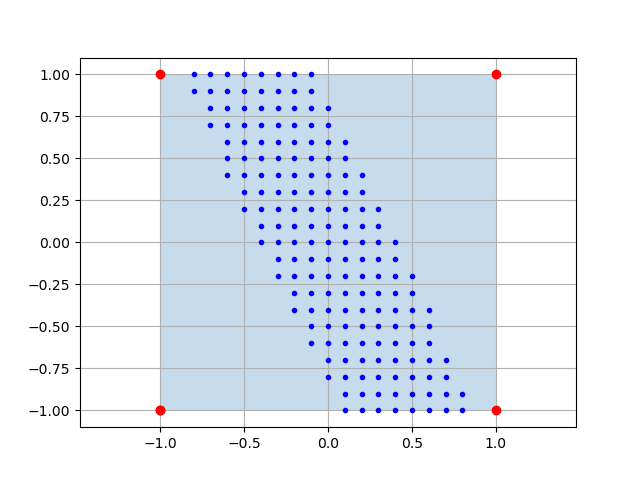

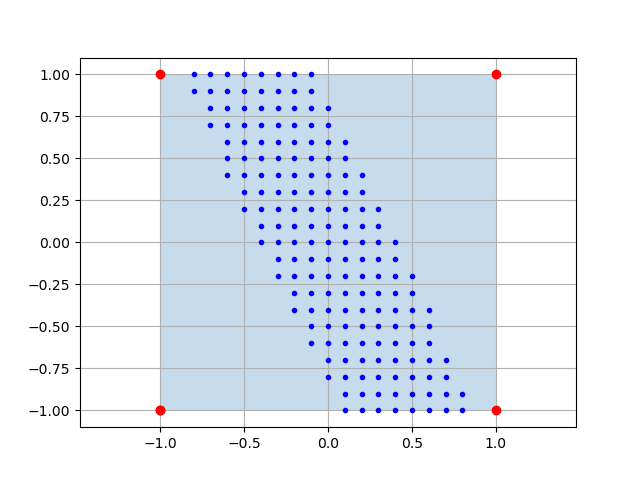

In [64]:
plot_polygon(A_con, b_con)
for pt in points:
    plt.plot([pt[0]], [pt[1]], 'bo', markersize=3)

F = A + B @ K

id_list = []
Ft = F
for i in range(3):
    plot_polygon(A_con, b_con)
    for k, pt in enumerate(points):
        pt_ = Ft @ pt
        if np.all(A_con @ pt_ <= b_con) and (k not in id_list):
            # plt.plot([pt_[0]], [pt_[1]], 'ro', markersize=3)
            plt.plot(pt[0], pt[1], 'bo', markersize=3)
        else:
            id_list.append(k)
    Ft = F @ Ft

In [65]:
def box_constraints(lb, ub):
    num_con = 2 * len(lb)
    A = np.kron(np.eye(len(lb)), [[1], [-1]])

    b = np.zeros(num_con)
    for i in range(num_con):
        b[i] = ub[i // 2] if i % 2 == 0 else -lb[i // 2]

    goodrows = np.logical_and(~np.isinf(b), ~np.isnan(b))
    A = A[goodrows]
    b = b[goodrows]
    
    return A, b

def compute_maximal_admissible_set(F, A, b, max_iter=100):
    dim_con = A.shape[0]
    A_inf_hist = []
    b_inf_hist = []

    Ft = F
    A_inf = A
    b_inf = b
    A_inf_hist.append(A_inf)
    b_inf_hist.append(b_inf)

    for t in range(max_iter):
        # print(f"t: {t}")
        f_obj = A @ Ft
        stop_flag = True
        for i in range(dim_con):
            x = solve_qp(np.zeros((2, 2)), -f_obj[i], A_inf, b_inf, solver="osqp")
            if f_obj[i] @ x > b[i]:
                stop_flag = False
                break

        if stop_flag:
            break
        
        A_inf = np.vstack((A_inf, A @ Ft))
        b_inf = np.hstack((b_inf, b))
        Ft = F @ Ft
        A_inf_hist.append(A_inf)
        b_inf_hist.append(b_inf)

    return A_inf_hist, b_inf_hist

def find_lqr_invariant_set(A, B, K, lb_x, ub_x, lb_u, ub_u):
    A_x, b_x = box_constraints(lb_x, ub_x)
    A_u, b_u = box_constraints(lb_u, ub_u)

    A_lqr = A_u @ K
    b_lqr = b_u

    A_con = np.vstack((A_lqr, A_x))
    b_con = np.hstack((b_lqr, b_x))

    F = A + B @ K

    # print(f"F:\n{F}")
    # print(f"A_con:\n{A_con}")
    # print(f"b_con:\n{b_con}")
    
    A_inf_hist, b_inf_hist = compute_maximal_admissible_set(F, A_con, b_con)

    return A_inf_hist, b_inf_hist


# dim_x = 2
# dim_u = 2
# A = np.array([[2., 1.], [0., 2.]])
# B = np.array([[1., 0.], [0., 1.]])

# Q = 10 * np.eye(dim_x)
# R = np.eye(dim_u)
# K = dlqr(A, B, Q, R)[0]
# K = -K  # sign convention

# lb_x = [-15, -np.inf]
# ub_x = [15, np.inf]
# lb_u = [-5, -5]
# ub_u = [5, 5]
# A_inf, b_inf = find_lqr_invariant_set(A, B, K, lb_x, ub_x, lb_u, ub_u)

# dim_x = 2
# dim_u = 1
# A = np.array([[1., 1.], [0., 1.]])
# B = np.array([[0.], [1.]])

# Q = np.eye(dim_x)
# R = 3
# K = dlqr(A, B, Q, R)[0]
# K = -K  # sign convention

# lb_x = [-0.75, -0.75]
# ub_x = [0.75, 0.75]
# lb_u = [-0.5]
# ub_u = [0.5]

A_inf_hist, b_inf_hist = find_lqr_invariant_set(A, B, K, lb_x, ub_x, lb_u, ub_u)

# print(A_inf_hist[-1])
# print(b_inf_hist[-1])

/Users/luyaozhang/opt/anaconda3/lib/python3.9/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/Users/luyaozhang/opt/anaconda3/lib/python3.9/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(


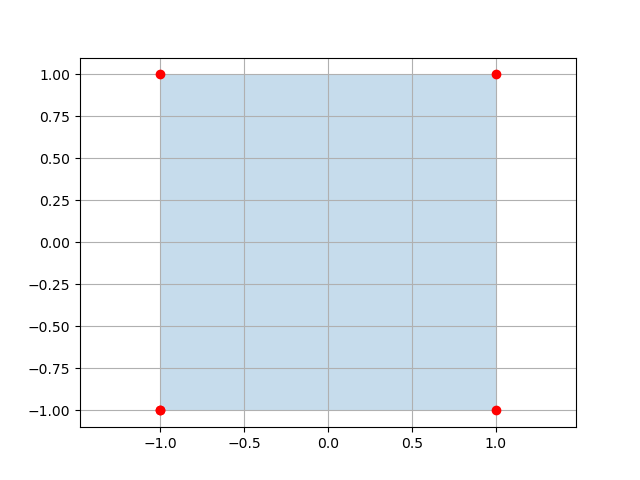

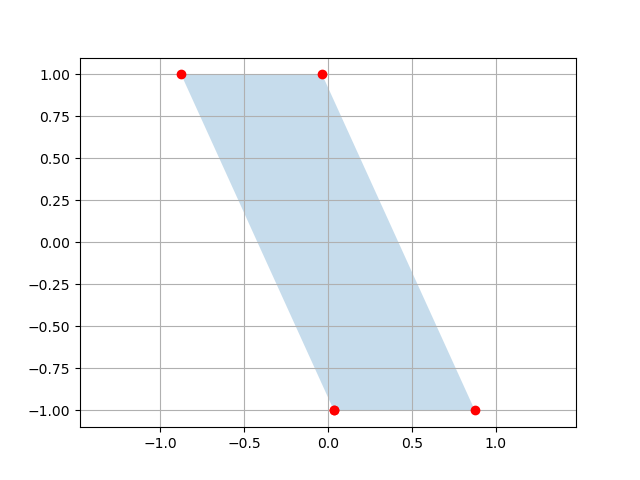

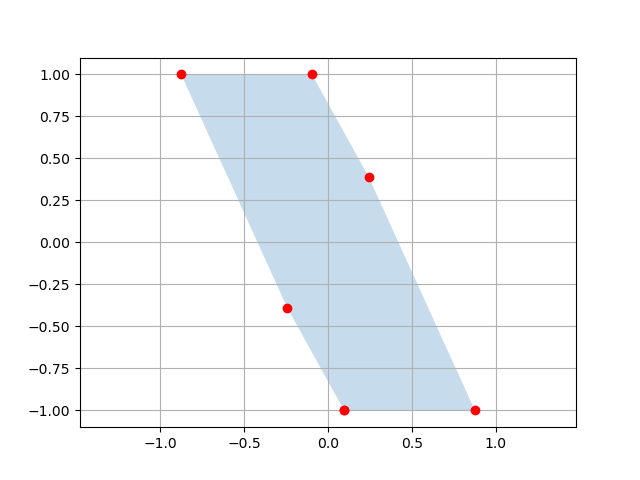

In [66]:


for A_inf, b_inf in zip(A_inf_hist, b_inf_hist):
    plot_polygon(A_inf, b_inf)

